In [1]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
columns = ['Date', 'Position_x', 'Position_y', 'Position_z']
df = pd.DataFrame(columns=columns)

with open('RawData/horizons_results_30_years.csv') as f:
    f.readline()
    for line in f:
        line = line.strip().split(',')

        date = line[0]
        position = np.array(list(map(np.float128, line[1:4])))
        new_row = pd.DataFrame([[date, *position]], columns=columns)
        df = pd.concat([df, new_row], ignore_index=True)


/tmp/ipykernel_875382/3046378181.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [4]:
#crop df from datetime.datetime(2021, 7, 17, 0, 0) to datetime.datetime(2022, 2, 27, 0, 0)
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= '2021-07-17') & (df['Date'] < '2022-02-27')]
df = df.reset_index(drop=True)
df.head()

,Date,Position_x,Position_y,Position_z
0,2021-07-17,-1.066699e+08,-1.458516e+07,5.939509e+06
1,2021-07-18,-1.060891e+08,-1.755816e+07,5.854842e+06
2,2021-07-19,-1.054376e+08,-2.047769e+07,5.768427e+06
3,2021-07-20,-1.047254e+08,-2.334597e+07,5.681332e+06
4,2021-07-21,-1.039609e+08,-2.616742e+07,5.594390e+06


In [5]:
#interpolation
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

#Convert time to number of days since the first date
time = (df['Date'] - df['Date'].iloc[0]).dt.days.reset_index(drop=True)

In [6]:
target_coordinates = np.empty((0, 3))

with open('RawData/horizons_results_target.csv') as f:
    for line in f:
        line = line.strip().split(',')
        position = np.array(list(map(np.float128, line)))
        target_coordinates = np.vstack((target_coordinates, position))

target_coordinates = target_coordinates[10:235] #Next revolution for Venus

In [7]:
def predictions(time, x_interpolator, y_interpolator, z_interpolator):
    x = x_interpolator(time)
    y = y_interpolator(time)
    z = z_interpolator(time)
    return np.array([x, y, z])

def plot_results(type, x_prediction, y_prediction, z_prediction, target_coordinates):
    plt.title(f'Using {type} interpolation')
    plt.plot(x_prediction, label='Predicted X')
    plt.plot(y_prediction, label='Predicted Y')
    plt.plot(z_prediction, label='Predicted Z')
    plt.plot(target_coordinates[:, 0], label='Target X')
    plt.plot(target_coordinates[:, 1], label='Target Y')
    plt.plot(target_coordinates[:, 2], label='Target Z')
    plt.legend()
    plt.show()

def plot_orbits(type, x_prediction, y_prediction, z_prediction, target_coordinates):
    fig = plt.figure()
    plt.title('Predicted Orbit using ' + type + ' interpolation')
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_prediction, y_prediction, z_prediction, label='Predicted Orbit')
    ax.plot(target_coordinates[:, 0], target_coordinates[:, 1], target_coordinates[:, 2], label='Target Orbit')
    ax.scatter(0, 0, 0, c='red', label='Sun')
    plt.legend()
    plt.show()

In [8]:
prediction_time = np.linspace(0, 225, 225, dtype=np.float128, endpoint=True)

In [9]:
cubic_interpol_x = interpolate.interp1d(time.to_numpy(), df['Position_x'], kind='cubic', fill_value='extrapolate')
cubic_interpol_y = interpolate.interp1d(time.to_numpy(), df['Position_y'], kind='cubic', fill_value='extrapolate')
cubic_interpol_z = interpolate.interp1d(time.to_numpy(), df['Position_z'], kind='cubic', fill_value='extrapolate')

quad_interpol_x = interpolate.interp1d(time.to_numpy(), df['Position_x'], kind='quadratic', fill_value='extrapolate')
quad_interpol_y = interpolate.interp1d(time.to_numpy(), df['Position_y'], kind='quadratic', fill_value='extrapolate')
quad_interpol_z = interpolate.interp1d(time.to_numpy(), df['Position_z'], kind='quadratic', fill_value='extrapolate')

In [10]:
cubic_prediction_x, cubic_prediction_y, cubic_prediction_z = predictions(prediction_time, cubic_interpol_x, cubic_interpol_y, cubic_interpol_z)
quad_prediction_x, quad_prediction_y, quad_prediction_z = predictions(prediction_time, quad_interpol_x, quad_interpol_y, quad_interpol_z)

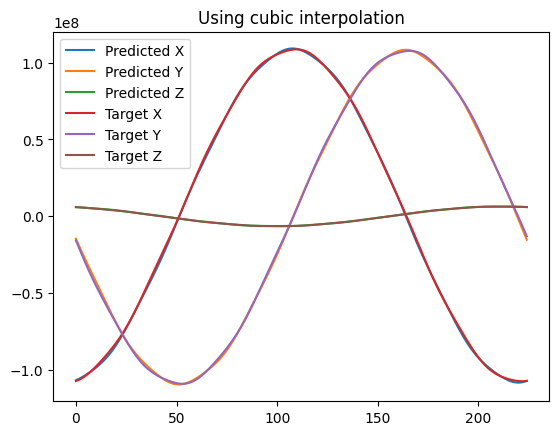

In [11]:
plot_results('cubic', cubic_prediction_x, cubic_prediction_y, cubic_prediction_z, target_coordinates)

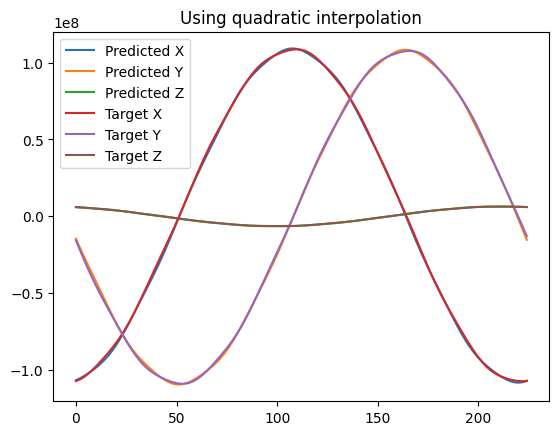

In [12]:
plot_results('quadratic', quad_prediction_x, quad_prediction_y, quad_prediction_z, target_coordinates)

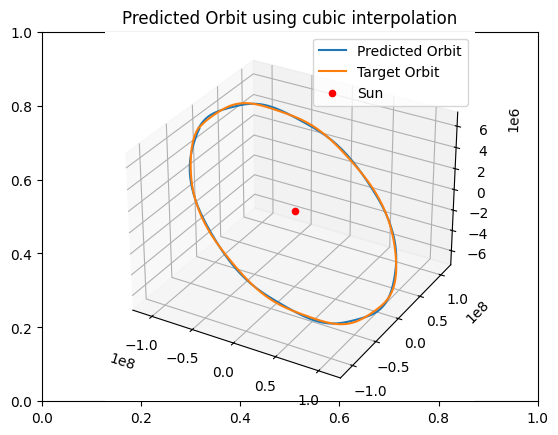

In [13]:
plot_orbits('cubic', cubic_prediction_x, cubic_prediction_y, cubic_prediction_z, target_coordinates)

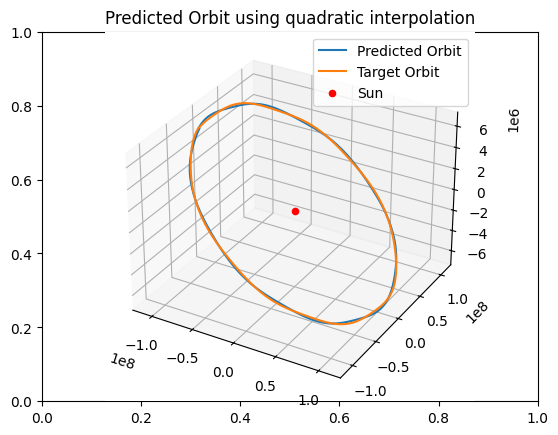

In [14]:
plot_orbits('quadratic', quad_prediction_x, quad_prediction_y, quad_prediction_z, target_coordinates)